# Accounting for seasonality

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm.notebook import tqdm
from itertools import product
from typing import Union

## Examining the SARIMA(p,d,q)(P,D,Q)m model

**The parameter m stands for the frequency.**

                     Minute           Hour       Day       Week         Year
    Daily                                                    7           365
    Hourly                                        24        168          8766
    Every minute                       60        1440      10080        525960
    Every second        60            3600       86400     604800       31557600

Mesečni podatki o potnikih na letalih.

In [2]:
df = pd.read_csv('data/air-passengers.csv')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


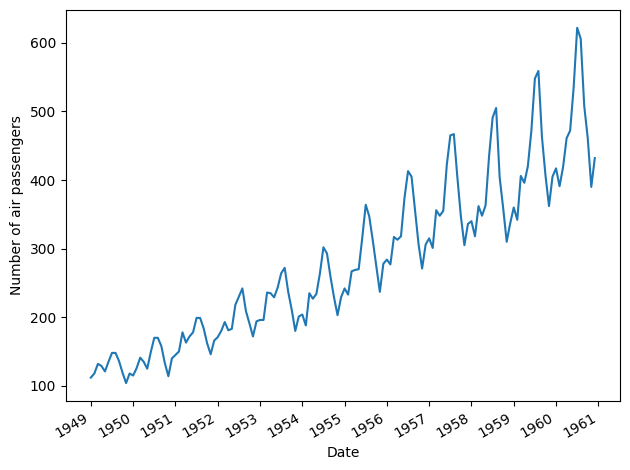

In [3]:
fig, ax = plt.subplots()

ax.plot(df['Month'], df['Passengers'])
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()

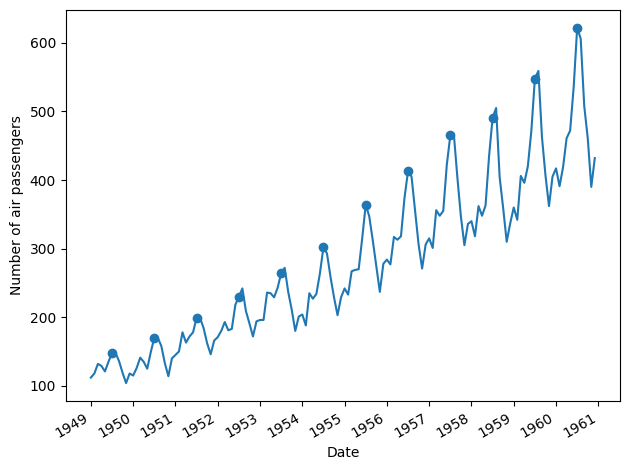

In [4]:
fig, ax = plt.subplots()

ax.plot(df['Month'], df['Passengers'], markevery=np.arange(6, 145, 12), marker='o')
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()

## Identifying seasonal patterns in a time series

**Usually, plotting the time series data is enough to observe periodic patterns.**

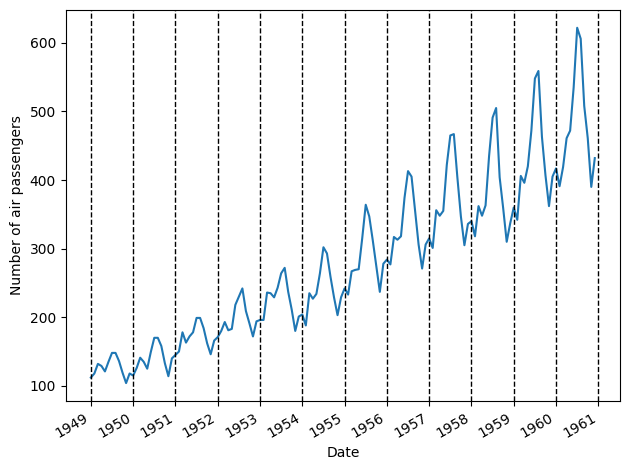

In [5]:
fig, ax = plt.subplots()

ax.plot(df['Month'], df['Passengers'])
for i in np.arange(0, 145, 12):
    ax.axvline(x=i, linestyle='--', color='black', linewidth=1)
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()

**Time series decomposition is
a statistical task that separates the time series into its three main components: a trend
component, a seasonal component, and the residuals.**

- **The trend component** represents the long-term change in the time series. This
component is responsible for time series that increase or decrease over time.
- **The seasonal component** is, of course, the seasonal pattern in the time series. It represents
repeated fluctuations that occur over a fixed period of time.
- **The residuals**, or the noise, express any irregularity that cannot be explained by the trend or the seasonal
component.

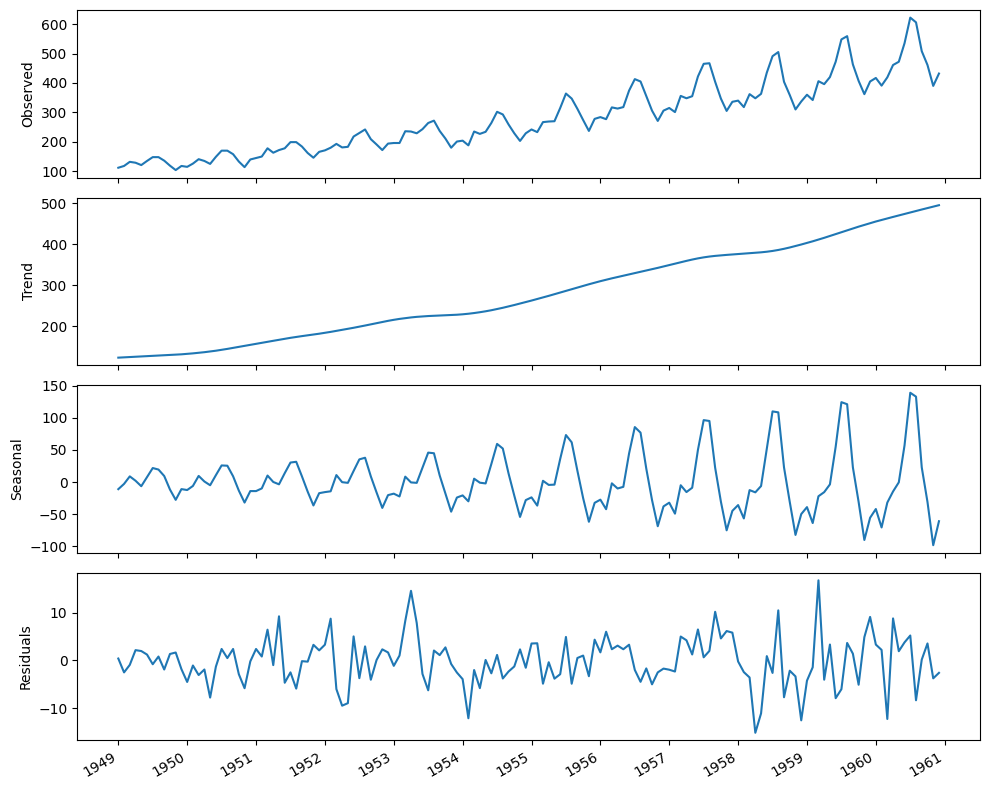

In [6]:
decomposition = STL(df['Passengers'], period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()

## Forecasting the number of monthly air passengers

<img src="images/tsf_08.png">

### Forecasting with an ARIMA(p,d,q) model

In [7]:
ad_fuller_result = adfuller(df['Passengers'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print("Critical values:")
for key, value in ad_fuller_result[4].items():
    print(f'   {key}: {value}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 0.8153688792060463
Critical values:
   1%: -3.4816817173418295
   5%: -2.8840418343195267
   10%: -2.578770059171598
p-value: 0.991880243437641


In [8]:
df_diff = np.diff(df['Passengers'], n=1)

ad_fuller_result = adfuller(df_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print("Critical values:")
for key, value in ad_fuller_result[4].items():
    print(f'   {key}: {value}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.8292668241699923
Critical values:
   1%: -3.4816817173418295
   5%: -2.8840418343195267
   10%: -2.578770059171598
p-value: 0.054213290283826474


In [9]:
df_diff_2 = np.diff(df_diff, n=1)

ad_fuller_result = adfuller(df_diff_2)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print("Critical values:")
for key, value in ad_fuller_result[4].items():
    print(f'   {key}: {value}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -16.384231542468516
Critical values:
   1%: -3.4816817173418295
   5%: -2.8840418343195267
   10%: -2.578770059171598
p-value: 2.7328918500141235e-29


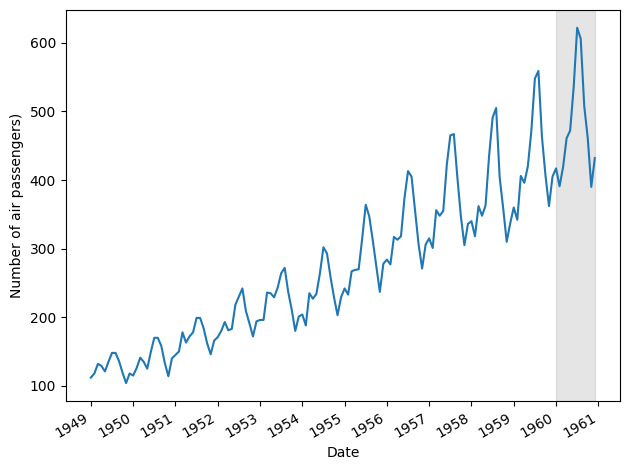

In [10]:
fig, ax = plt.subplots()

ax.plot(df['Month'], df['Passengers'])
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers)')
ax.axvspan(132, 143, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()

In [11]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm(order_list):
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [12]:
import warnings
warnings.filterwarnings('ignore')

ps = range(0, 13, 1)
qs = range(0, 13, 1)
Ps = [0]
Qs = [0]

d = 2
D = 0
s = 12

ARIMA_order_list = list(product(ps, qs, Ps, Qs))

train = df['Passengers'][:-12]

ARIMA_result_df = optimize_SARIMA(train, ARIMA_order_list, d, D, s)
ARIMA_result_df

  0%|          | 0/169 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(11, 3, 0, 0)",1016.837629
1,"(11, 4, 0, 0)",1019.018619
2,"(12, 0, 0, 0)",1020.143603
3,"(11, 5, 0, 0)",1020.379122
4,"(11, 1, 0, 0)",1021.027950
...,...,...
164,"(5, 0, 0, 0)",1281.732157
165,"(3, 0, 0, 0)",1300.282335
166,"(2, 0, 0, 0)",1302.913196
167,"(1, 0, 0, 0)",1308.152194


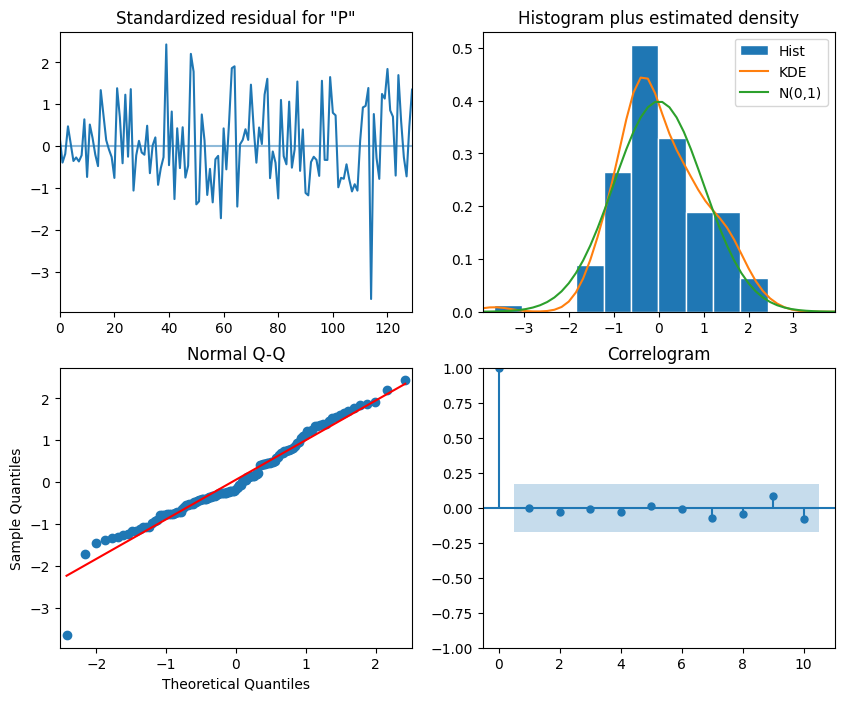

In [13]:
ARIMA_model = SARIMAX(train, order=(11,2,3), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)
ARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [14]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = ARIMA_model_fit.resid
res = acorr_ljungbox(residuals, np.arange(1, 11, 1))
print(list(res["lb_pvalue"]))

[0.010403540938885639, 0.03521818491114037, 0.07264196879213503, 0.10056437871617054, 0.13513404909274546, 0.19182810553488336, 0.21899254386100586, 0.28416316315631857, 0.37151102040177164, 0.3166126334633808]


In [15]:
test = df.iloc[-12:]

test['naive_seasonal'] = df['Passengers'].iloc[120:132].values
test

,Month,Passengers,naive_seasonal
132,1960-01,417,360
133,1960-02,391,342
134,1960-03,419,406
135,1960-04,461,396
136,1960-05,472,420
137,1960-06,535,472
138,1960-07,622,548
139,1960-08,606,559
140,1960-09,508,463
141,1960-10,461,407


In [16]:
ARIMA_pred = ARIMA_model_fit.get_prediction(132, 143).predicted_mean
test['ARIMA_pred'] = ARIMA_pred

### Forecasting with a SARIMA(p,d,q)(P,D,Q)m model

In [18]:
ad_fuller_result = adfuller(df['Passengers'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print("Critical values:")
for key, value in ad_fuller_result[4].items():
    print(f'   {key}: {value}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 0.8153688792060463
Critical values:
   1%: -3.4816817173418295
   5%: -2.8840418343195267
   10%: -2.578770059171598
p-value: 0.991880243437641


In [19]:
df_diff = np.diff(df['Passengers'], n=1)
ad_fuller_result = adfuller(df_diff)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print("Critical values:")
for key, value in ad_fuller_result[4].items():
    print(f'   {key}: {value}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.8292668241699923
Critical values:
   1%: -3.4816817173418295
   5%: -2.8840418343195267
   10%: -2.578770059171598
p-value: 0.054213290283826474


In [20]:
df_diff_2 = np.diff(df_diff, n=1)

ad_fuller_result = adfuller(df_diff_2)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print("Critical values:")
for key, value in ad_fuller_result[4].items():
    print(f'   {key}: {value}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -16.384231542468516
Critical values:
   1%: -3.4816817173418295
   5%: -2.8840418343195267
   10%: -2.578770059171598
p-value: 2.7328918500141235e-29


In [21]:
df_diff_seasonal_diff = np.diff(df['Passengers'], n=12)

ad_fuller_result = adfuller(df_diff_seasonal_diff)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print("Critical values:")
for key, value in ad_fuller_result[4].items():
    print(f'   {key}: {value}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -16.343415591645634
Critical values:
   1%: -3.4870216863700767
   5%: -2.8863625166643136
   10%: -2.580009026141913
p-value: 2.9805039720077054e-29


In [22]:
ps = range(0, 3, 1)
qs = range(0, 3, 1)
Ps = range(0, 3, 1)
Qs = range(0, 3, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

train = df['Passengers'][:-12]

d = 2
D = 1
s = 12

SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/81 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(2, 2, 1, 2)",892.181181
1,"(2, 2, 2, 1)",893.174017
2,"(1, 1, 1, 2)",894.415740
3,"(1, 1, 2, 1)",895.182679
4,"(0, 2, 1, 2)",895.261702
...,...,...
76,"(0, 0, 2, 0)",1004.515070
77,"(0, 0, 0, 0)",1004.691880
78,"(0, 0, 2, 2)",1005.651556
79,"(0, 0, 2, 1)",1006.262253


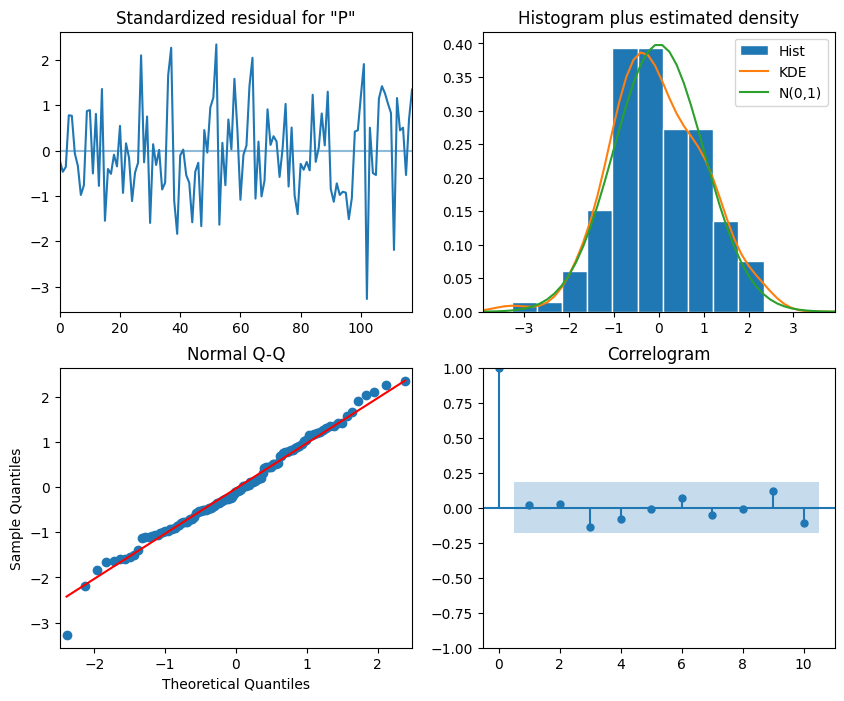

In [25]:
SARIMA_model = SARIMAX(train, order=(2,d,2), seasonal_order=(1,D,2,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [26]:
from statsmodels.stats.diagnostic import acorr_ljungbox
residuals = SARIMA_model_fit.resid
res = acorr_ljungbox(residuals, np.arange(1, 11, 1))
print(list(res["lb_pvalue"]))

[0.00017776109218163157, 0.0006050147709364377, 0.0010278035726128682, 0.0019761480797421366, 0.0033225894013591806, 0.006055226351580901, 0.00960387445163835, 0.016995310203239085, 0.027112024226340348, 0.023702385306066606]


---

In [27]:
ps = range(0, 3, 1)
qs = range(0, 3, 1)
Ps = range(0, 3, 1)
Qs = range(0, 3, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

train = df['Passengers'][:-12]

d = 1
D = 1
s = 12

SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/81 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(2, 1, 1, 2)",892.244697
1,"(2, 1, 2, 1)",893.630739
2,"(1, 0, 1, 2)",894.287707
3,"(0, 1, 1, 2)",894.995438
4,"(1, 0, 2, 1)",895.095845
...,...,...
74,"(0, 0, 1, 0)",905.225875
75,"(0, 0, 0, 1)",905.418880
76,"(0, 0, 1, 1)",906.058318
77,"(0, 0, 0, 2)",906.888588


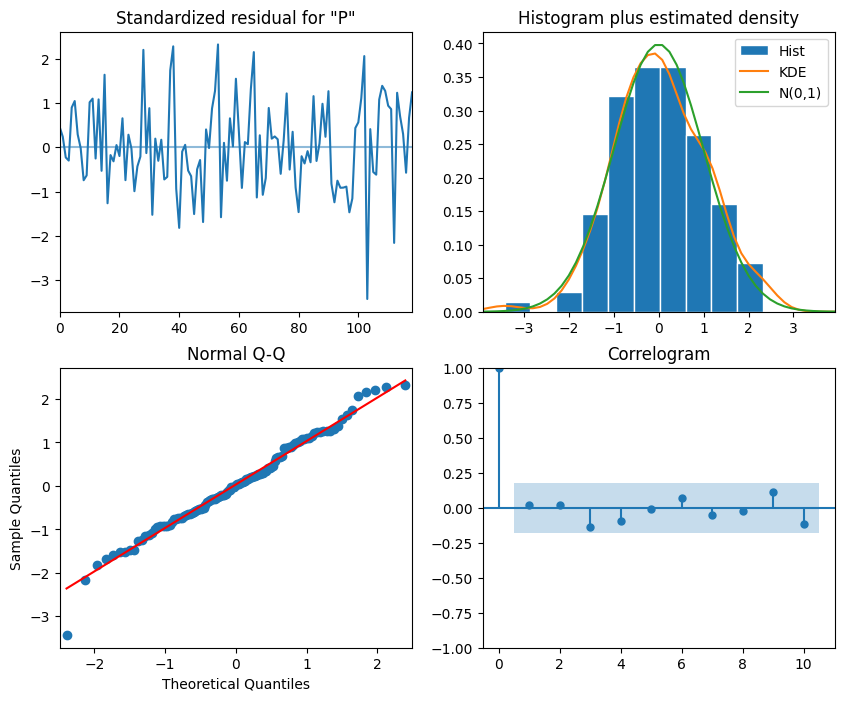

In [28]:
SARIMA_model = SARIMAX(train, order=(2,d,1), seasonal_order=(1,D,2,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [31]:
from statsmodels.stats.diagnostic import acorr_ljungbox
residuals = SARIMA_model_fit.resid
res = acorr_ljungbox(residuals, np.arange(1, 11, 1))
print(list(res["lb_pvalue"]))

[0.9447410789702719, 0.6888201744387643, 0.7959937674695672, 0.8737688587607175, 0.9203114702392728, 0.9441978289273373, 0.9408547352405284, 0.9508074889459499, 0.9739162942066675, 0.893265496295069]


In [32]:
SARIMA_pred = SARIMA_model_fit.get_prediction(132, 143).predicted_mean

test['SARIMA_pred'] = SARIMA_pred
test

,Month,Passengers,naive_seasonal,ARIMA_pred,SARIMA_pred
132,1960-01,417,360,422.384224,418.518748
133,1960-02,391,342,410.629649,399.579466
134,1960-03,419,406,461.818310,461.316463
135,1960-04,461,396,457.843608,451.444618
136,1960-05,472,420,481.712027,473.751433
137,1960-06,535,472,531.130137,538.789755
138,1960-07,622,548,606.151794,612.469991
139,1960-08,606,559,615.492588,624.648875
140,1960-09,508,463,525.632186,520.183520
141,1960-10,461,407,467.114135,462.856067


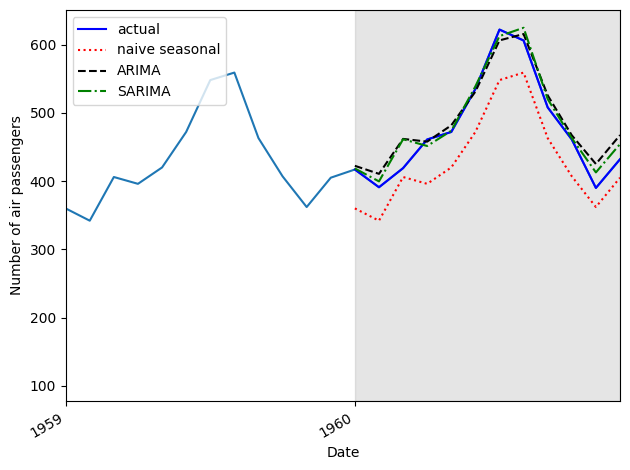

In [33]:
fig, ax = plt.subplots()

ax.plot(df['Month'], df['Passengers'])
ax.plot(test['Passengers'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA')
ax.plot(test['SARIMA_pred'], 'g-.', label='SARIMA')

ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')
ax.axvspan(132, 143, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))
ax.set_xlim(120, 143)

fig.autofmt_xdate()
plt.tight_layout()

In [34]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [35]:
mape_naive_seasonal = mape(test['Passengers'], test['naive_seasonal'])
mape_ARIMA = mape(test['Passengers'], test['ARIMA_pred'])
mape_SARIMA = mape(test['Passengers'], test['SARIMA_pred'])

print(mape_naive_seasonal, mape_ARIMA, mape_SARIMA)

9.987532920823485 3.840866653910586 2.8498839510179277


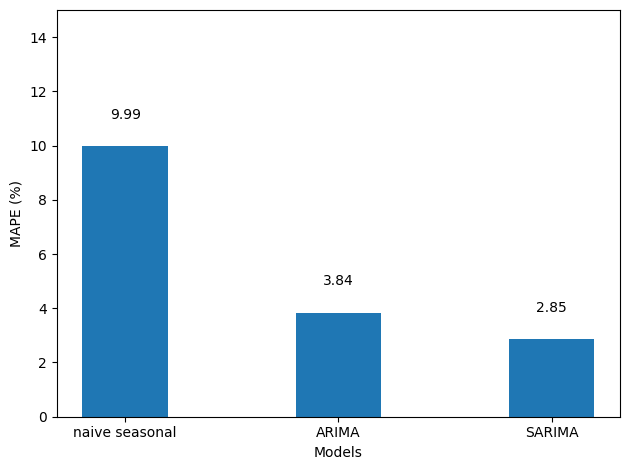

In [36]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'ARIMA', 'SARIMA']
y = [mape_naive_seasonal, mape_ARIMA, mape_SARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()

## Summary

- The seasonal autoregressive integrated moving average model, denoted as
SARIMA(p,d,q)(P,D,Q)m, adds seasonal properties to the ARIMA(p,d,q) model.
- P is the order of the seasonal autoregressive process, D is the order of seasonal
integration, Q is the order of the seasonal moving average process, and m is the
frequency of the data.
- The frequency m corresponds to the number of observations in a cycle. If the
data is collected every month, then m = 12. If data is collected every quarter,
then m = 4.
- Time series decomposition can be used to identify seasonal patterns in a time
series.